In [1]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
import os
import polars as pl
import random
import pickle

import lightgbm as lgb

In [2]:
class Config:
    PREPROCESS = False
    KAGGLE_NOTEBOOK = False
    DEBUG = True
    SEED = 42
    LR = 1e-3
    WD = 1e-6
    EARLY_STOPPING = False
    NOTEBOOK = True
    
    
if Config.DEBUG:
    n_rows = 10**4
else:
    n_rows = None

if Config.KAGGLE_NOTEBOOK:
    RAW_DIR = "/kaggle/input/isic-2024-challenge"
    OUTPUT_DIR = ""
    MODEL_DIR = ""
    
else:
    RAW_DIR = "../data/raw/"
    PROCESSED_DIR = "../data/processed/"
    OUTPUT_DIR = "../data/result/"
    MODEL_DIR = "../models/"
    LOG_DIR = "../data/logs"
    LOSS_DIR = "../data/losses"


In [3]:
df_train = pl.read_csv(os.path.join(RAW_DIR, "train-metadata.csv"), n_rows=n_rows).to_pandas()
df_test = pd.read_csv(os.path.join(RAW_DIR, "test-metadata.csv"))

In [4]:
df_train["clin_size_long_diam_mm"] = df_train["clin_size_long_diam_mm"].astype(float)
df_train["age_approx"][df_train["age_approx"] == "NA"] = np.nan
df_train["age_approx"] = df_train["age_approx"].astype(float)

/tmp/ipykernel_106810/911935499.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train["age_approx"][df_train["age_approx"] == "NA"] = np.nan
/tmp/ipykernel_106810/911935499.py:2: SettingWithCopyWarning: 
A value is trying to be set on

In [5]:


def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
    
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
] + new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

In [6]:
gkf = GroupKFold(n_splits=5) # , shuffle=True, random_state=42

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

In [7]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [8]:




__n_estimators         = random.choice([1400,1500,2000])                  # 800,900,1000,1100,1200,1300,
__learning_rate        = random.choice([0.003,0.002,0.001])               # 0.005,0.004,
__lambda_l1            = random.choice([0.14,0.21,0.27,0.37])
__lambda_l2            = random.choice([0.7,1.0,1.47,1.77,2.77])
__pos_bagging_fraction = random.choice([0.74, 0.75, 0.77, 0.777])
__neg_bagging_fraction = random.choice([0.04,0.05,0.07,0.077])
__feature_fraction     = random.choice([0.5,0.54,0.57,0.7,0.77,0.777])
__num_leaves           = random.choice([16, 20, 24, 30,33,37])            # 24,30,31,32,33,37
__min_data_in_leaf     = random.choice([16, 20, 24, 40,50,57])            # 40,45,50,55,57

lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators":__n_estimators,
    'learning_rate':__learning_rate,
    'num_leaves':__num_leaves,
    'min_data_in_leaf':__min_data_in_leaf,
    'bagging_freq': 1,
    'pos_bagging_fraction':__pos_bagging_fraction,
    'neg_bagging_fraction':__neg_bagging_fraction,
    'feature_fraction':__feature_fraction,
    'lambda_l1':__lambda_l1,
    'lambda_l2':__lambda_l2,
    "verbosity": -1,
    # "extra_trees": True
}

print('\n',
      __n_estimators,
      __learning_rate,
      __lambda_l1,
      __lambda_l2,
      __pos_bagging_fraction,
      __neg_bagging_fraction,
      __feature_fraction,
      __num_leaves,
      __min_data_in_leaf,
'\n')



 1400 0.001 0.14 1.0 0.77 0.05 0.54 16 57 



In [9]:

scores = []
models = []
for fold in range(5):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(
        **lgb_params
    )
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    scores.append(score)
    models.append(model)

fold: 0 - Partial AUC Score: 0.13176
fold: 1 - Partial AUC Score: 0.12068
fold: 2 - Partial AUC Score: 0.17389
fold: 3 - Partial AUC Score: 0.19510
fold: 4 - Partial AUC Score: 0.10686


In [11]:
with open(os.path.join(MODEL_DIR, "models.pkl"), 'wb') as f:
    pickle.dump(models, f)


In [26]:
np.mean(scores)

0.13702946703805227

In [14]:
importances = np.mean([model.feature_importances_ for model in models], 0)
df_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)

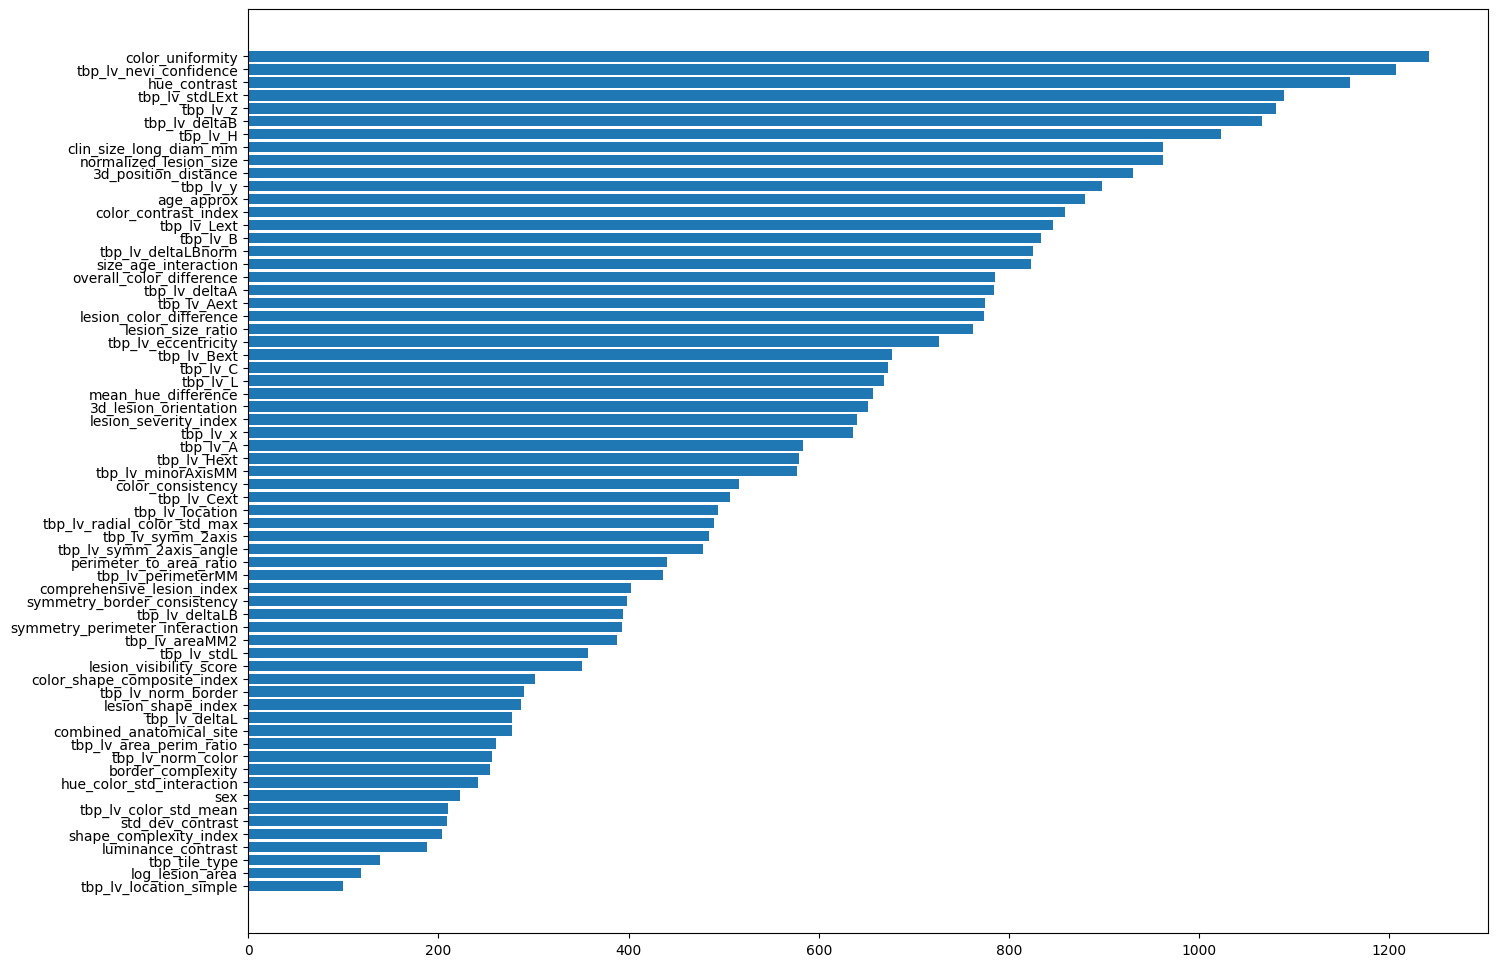

In [15]:
plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()

In [16]:
# How does the new feature(s) perform?
# I would go with the > 20 in the index.
df_imp[df_imp["feature"].isin(new_num_cols + new_cat_cols)].sort_values("importance", ascending=False)

,feature,importance
64,color_uniformity,1241.6
62,hue_contrast,1158.6
56,normalized_lesion_size,961.4
55,3d_position_distance,930.8
52,color_contrast_index,859.2
48,size_age_interaction,822.6
47,overall_color_difference,784.8
44,lesion_color_difference,773.8
43,lesion_size_ratio,761.8
38,mean_hue_difference,656.6


In [17]:
X_cat = category_encoder.fit_transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

In [18]:
preds = np.mean([model.predict(df_test[train_cols]) for model in models], 0)

In [20]:
df_sub = pd.read_csv(os.path.join(raw_path, "sample_submission.csv"))
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.001890
1,ISIC_0015729,0.001112
2,ISIC_0015740,0.002911


In [22]:
df_sub.to_csv("../data/result/submission.csv", index=False)